#### EDA of Futures Interest Rates

This notebook performs an exploratory data analysis on futures interest rate contracts.
 * The dataset consists of daily time series for futures interest rates across different maturities.
 * It calculate key descriptive statistics (e.g., mean, median, standard deviation, min, max) for each contract maturity.
 * It show the evolution of interest rates and their volatility.
 * It also analyse the schocks for both minute decision, and minute release.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
INITIAL_DATE = "2003-06-26"

In [3]:
minutes_info = pd.read_excel("./data/raw/minutes_info.xlsx")
minutes_info = minutes_info[minutes_info["DataReferencia"] >= INITIAL_DATE]
minutes_info = minutes_info.sort_values("DataReferencia", ascending=True)

dates_ref = minutes_info["DataReferencia"]
detes_pub = minutes_info["DataPublicacao"]

In [4]:
futures_ir = pd.read_excel("./data/future_interest_rates/future_interest_rates.xlsx", index_col="Date")
futures_ir.index = pd.to_datetime(futures_ir.index)
futures_ir.sort_index(inplace=True)

futures_ir_returns = futures_ir.pct_change().dropna()

In [5]:
futures_ir.describe()

,v_21,v_63,v_126,v_252,v_504
count,5556.000000,5556.000000,5556.000000,5556.000000,5556.000000
mean,11.183686,11.195921,11.247197,11.360647,11.640164
std,4.299972,4.229452,4.125726,3.935952,3.574634
min,1.892000,1.870250,1.868667,2.196500,3.238846
25%,8.597250,8.600000,8.709850,8.967525,9.537642
50%,11.171000,11.219857,11.329795,11.448450,11.755900
75%,13.662125,13.721250,13.815833,13.750150,13.452684
max,26.160000,25.750000,24.675000,23.605000,23.664762


In [6]:
futures_ir_returns.std()

v_21     0.004132
v_63     0.005803
v_126    0.008420
v_252    0.011551
v_504    0.013820
dtype: float64

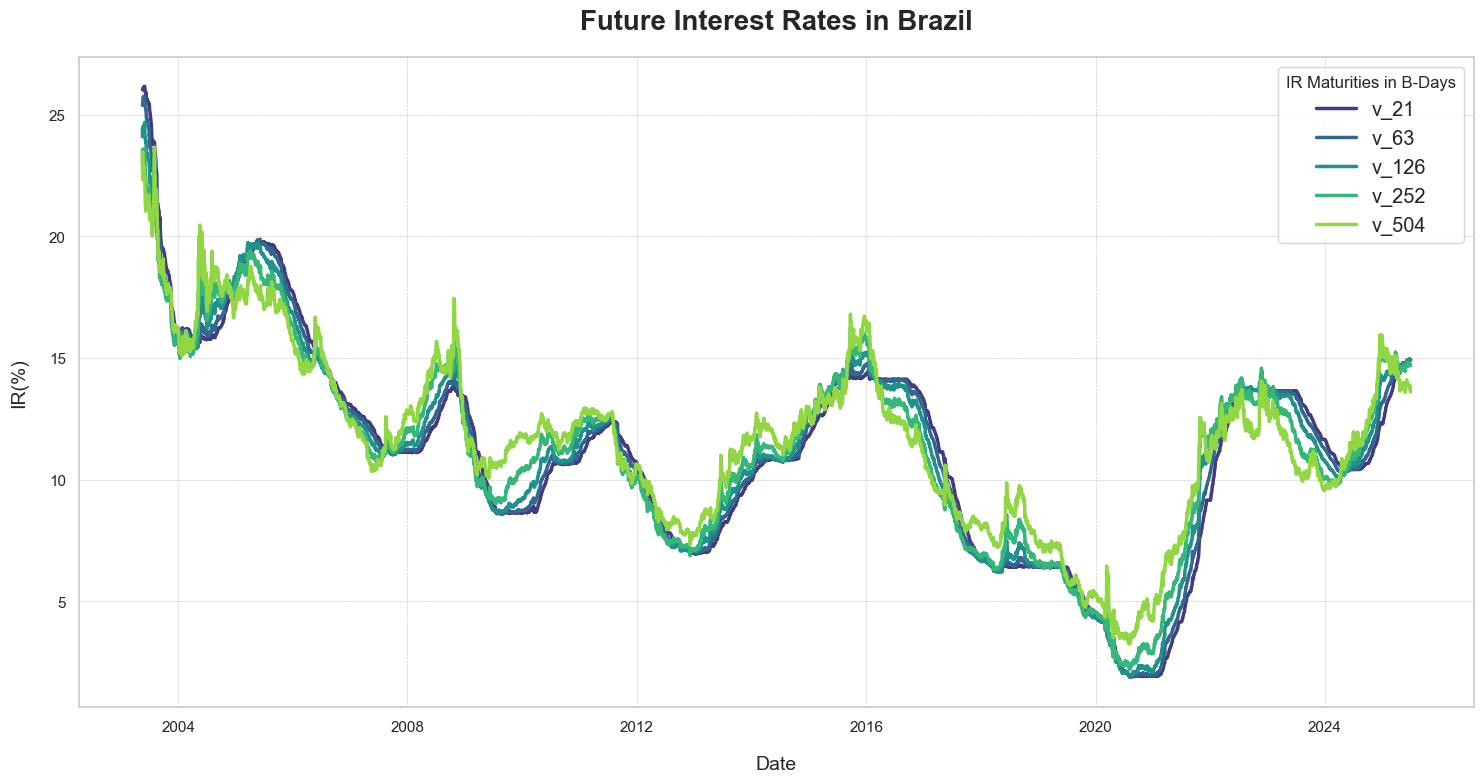

In [7]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15, 8))
line_plot = sns.lineplot(data=futures_ir, dashes=False, palette="viridis", linewidth=2.5)

plt.title("Future Interest Rates in Brazil", fontsize=20, weight='bold', pad=20)
plt.xlabel('Date', fontsize=14, labelpad=15)
plt.ylabel('IR(%)', fontsize=14, labelpad=15)
plt.legend(title="IR Maturities in B-Days", fontsize='large', title_fontsize='medium')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()


In [8]:
def calc_vol(retornos: pd.Series) -> float:
    vol = retornos.std() * np.sqrt(252)
    return vol



mw_volatility_252 = futures_ir_returns.rolling(252).apply(calc_vol)*100
mw_volatility_252 = mw_volatility_252.dropna()

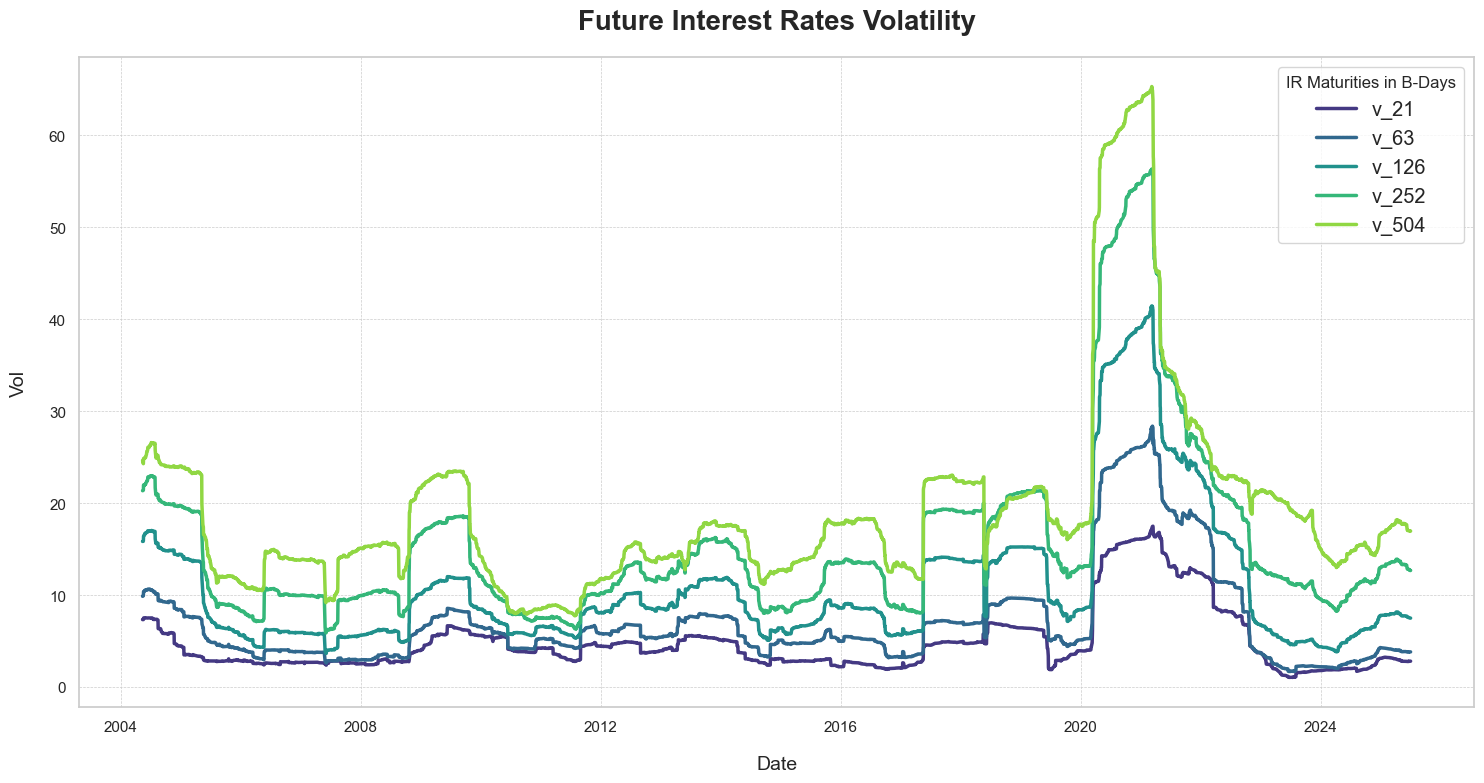

In [9]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15, 8))
line_plot = sns.lineplot(data=mw_volatility_252, dashes=False, palette="viridis", linewidth=2.5)

plt.title("Future Interest Rates Volatility", fontsize=20, weight='bold', pad=20)
plt.xlabel('Date', fontsize=14, labelpad=15)
plt.ylabel('Vol', fontsize=14, labelpad=15)
plt.legend(title="IR Maturities in B-Days", fontsize='large', title_fontsize='medium')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()


#### Studing minutes schocks

In [10]:
pd.options.mode.chained_assignment = None

def series_around_schock(df, dates, window_days=3):
    events_windows = []
    df.sort_index(inplace=True)

    for event_date in dates:
        try:
            event_loc = df.index.get_loc(event_date)
        except KeyError:
            continue

        start_loc = event_loc - window_days
        end_loc = event_loc + window_days + 1

        if start_loc < 0:
            start_loc = 0

        window_data = df.iloc[start_loc:end_loc]
        
        if window_data.empty or len(window_data) < (window_days*2 + 1):
            continue
        
        window_data['days_from_event'] = np.arange(-3,4)
        window_data.set_index('days_from_event', inplace=True)
        window_data.columns = [event_date.strftime('%Y-%m-%d')]
        events_windows.append(window_data)
        
    events_windows = pd.concat(events_windows, axis=1)
    events_windows.sort_index(inplace=True)
    return events_windows

In [11]:
vertix_list = futures_ir_returns.columns.tolist()
print(vertix_list)
vertix = "v_252"
futures_ir_returns_vertix = futures_ir_returns[[vertix]]

['v_21', 'v_63', 'v_126', 'v_252', 'v_504']


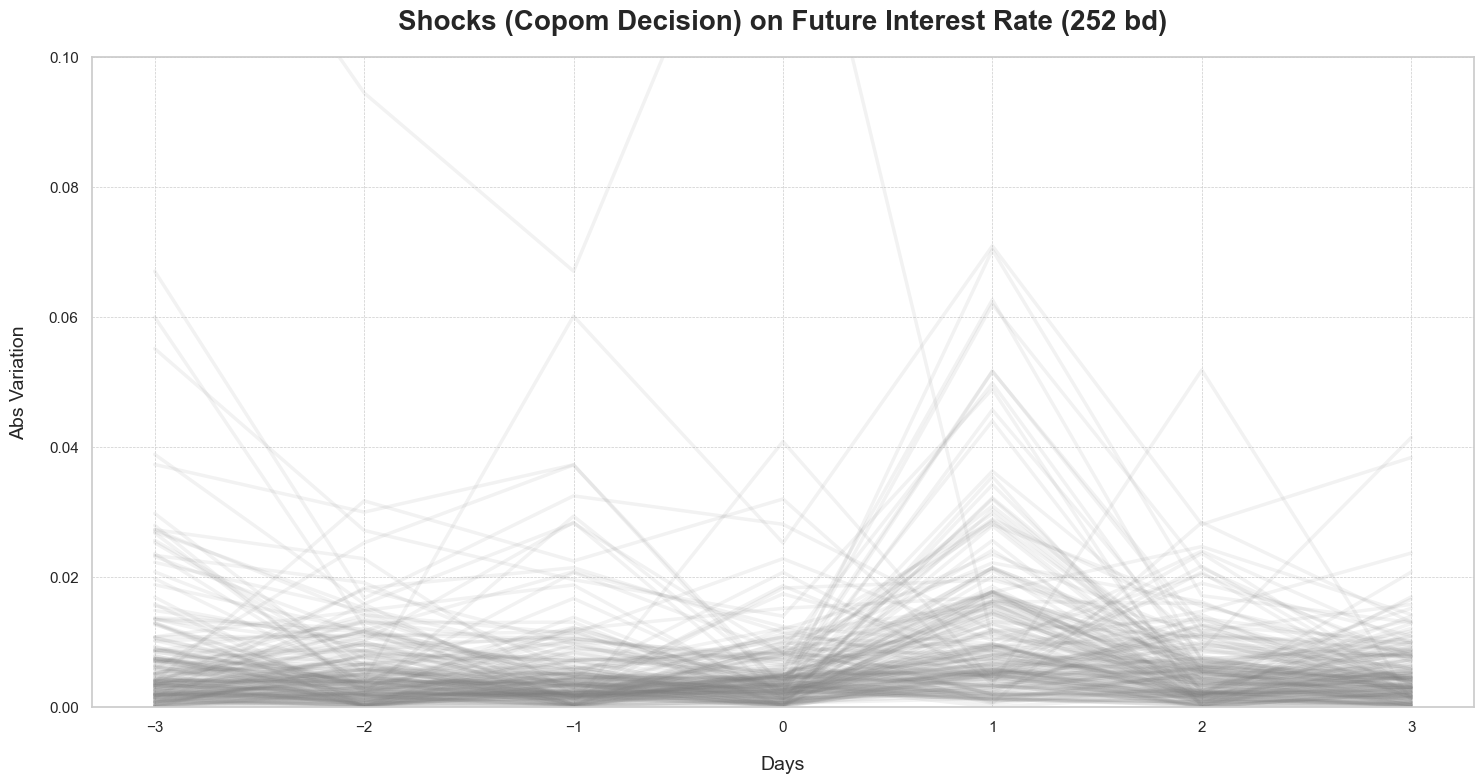

In [12]:
#Shocks for the copom decision

df_shocks_ref = series_around_schock(futures_ir_returns_vertix, dates_ref)
df_shocks_ref = df_shocks_ref.abs()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 8))
df_shocks_ref.plot(ax=plt.gca(), legend=False, color='gray', linewidth=2.5, alpha=0.1)
plt.title(f"Shocks (Copom Decision) on Future Interest Rate ({vertix.replace('v_', '')} bd)", fontsize=20, weight='bold', pad=20)
plt.xlabel('Days', fontsize=14, labelpad=15)
plt.ylabel('Abs Variation', fontsize=14, labelpad=15)
plt.ylim(0, 0.1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

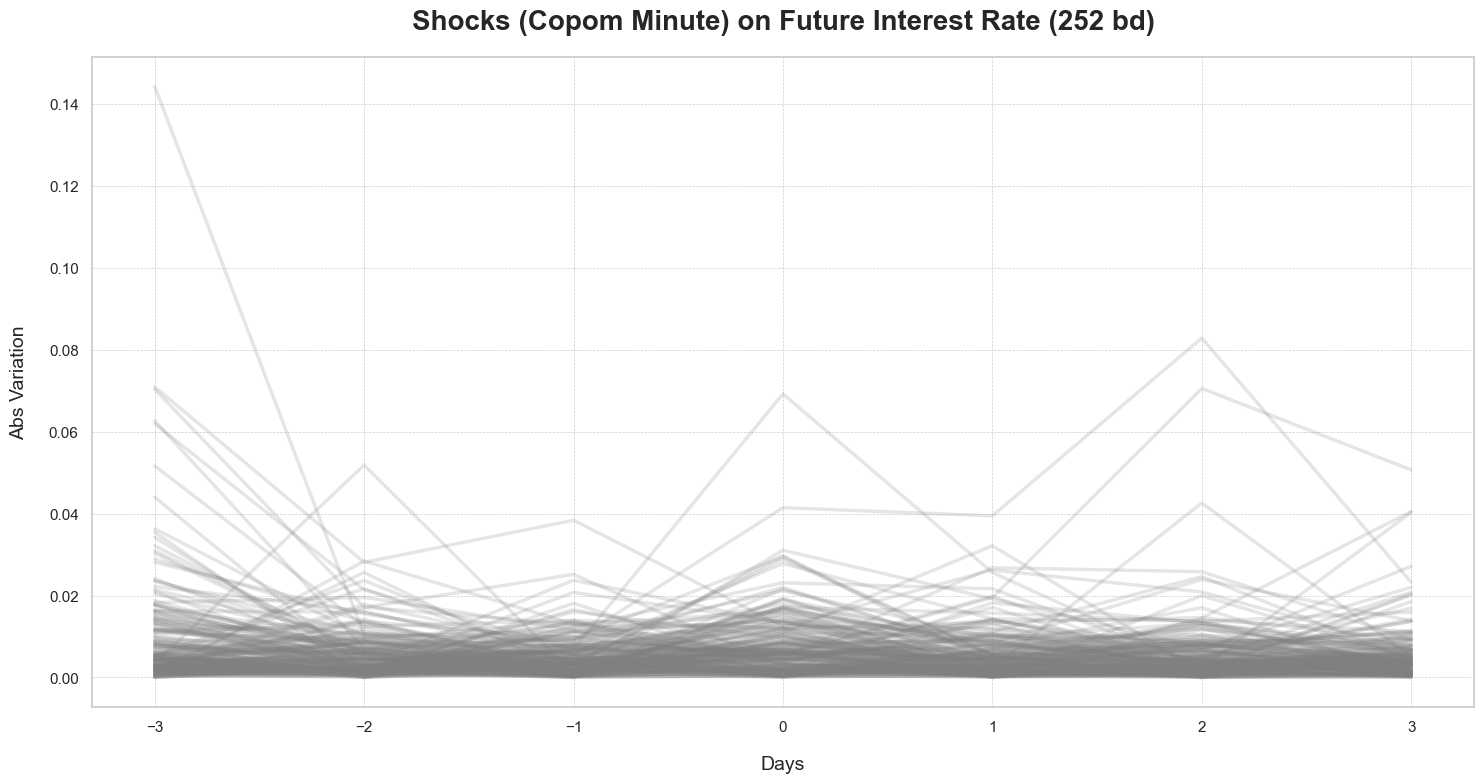

In [13]:
#Shocks for the copom minute

df_shocks_pub = series_around_schock(futures_ir_returns_vertix, detes_pub)
df_shocks_pub = df_shocks_pub.abs()

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 8))
df_shocks_pub.plot(ax=plt.gca(), legend=False, color='gray', linewidth=2.5, alpha=0.2)
plt.title(f"Shocks (Copom Minute) on Future Interest Rate ({vertix.replace('v_', '')} bd)", fontsize=20, weight='bold', pad=20)
plt.xlabel('Days', fontsize=14, labelpad=15)
plt.ylabel('Abs Variation', fontsize=14, labelpad=15)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


#### Iterating to make graph

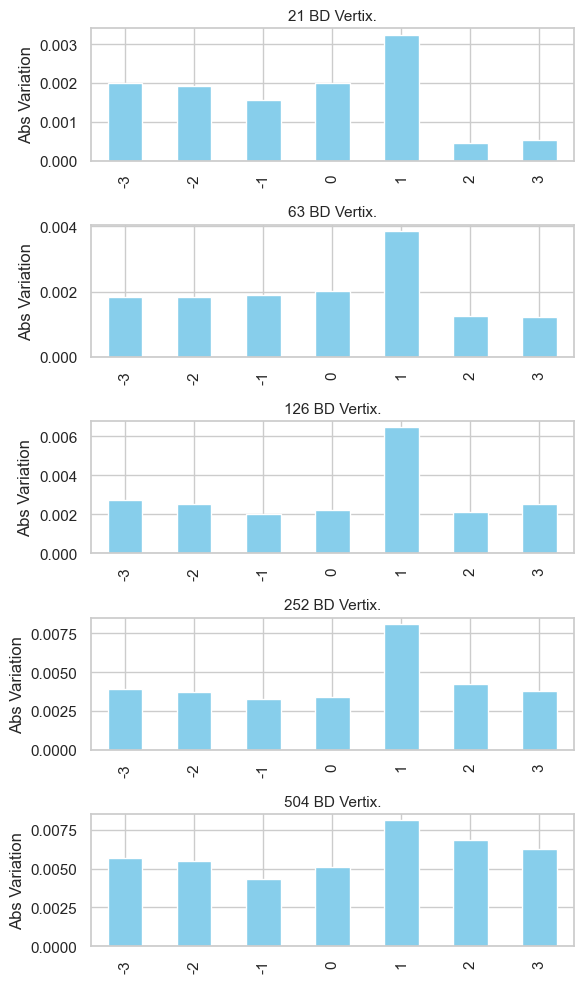

In [14]:
#### Median Absolute Change in Futures Interest Rates Around COPOM Decisions

fig, axs = plt.subplots(len(vertix_list), 1, figsize=(6, 2 * len(vertix_list)))

for i, vertix in enumerate(vertix_list):
    futures_ir_returns_vertix = futures_ir_returns[[vertix]]
    df_shocks_ref = series_around_schock(futures_ir_returns_vertix, dates_ref)
    df_shocks_ref = df_shocks_ref.abs()

    df_shocks_ref_median = df_shocks_ref.median(axis=1)
    df_shocks_ref_median.plot(kind='bar', ax=axs[i], color='skyblue')
    
    axs[i].set_title(f"{vertix.replace("v_", "")} BD Vertix.", fontsize=11)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Abs Variation')

plt.tight_layout()

plt.show()

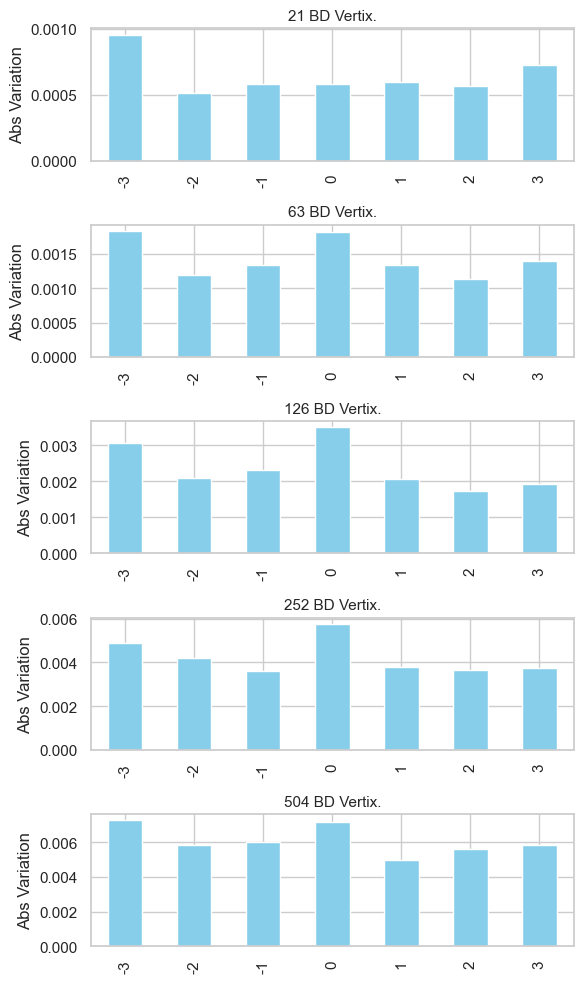

In [15]:
#### Median Absolute Change in Futures Interest Rates Around Release of Minute.

fig, axs = plt.subplots(len(vertix_list), 1, figsize=(6, 2 * len(vertix_list)))

for i, vertix in enumerate(vertix_list):
    futures_ir_returns_vertix = futures_ir_returns[[vertix]]
    df_shocks_pub = series_around_schock(futures_ir_returns_vertix, detes_pub)
    df_shocks_pub = df_shocks_pub.abs()

    df_shocks_pub_median = df_shocks_pub.median(axis=1)
    df_shocks_pub_median.plot(kind='bar', ax=axs[i], color='skyblue')
    
    axs[i].set_title(f"{vertix.replace("v_", "")} BD Vertix.", fontsize=11)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Abs Variation')

plt.tight_layout()

plt.show()

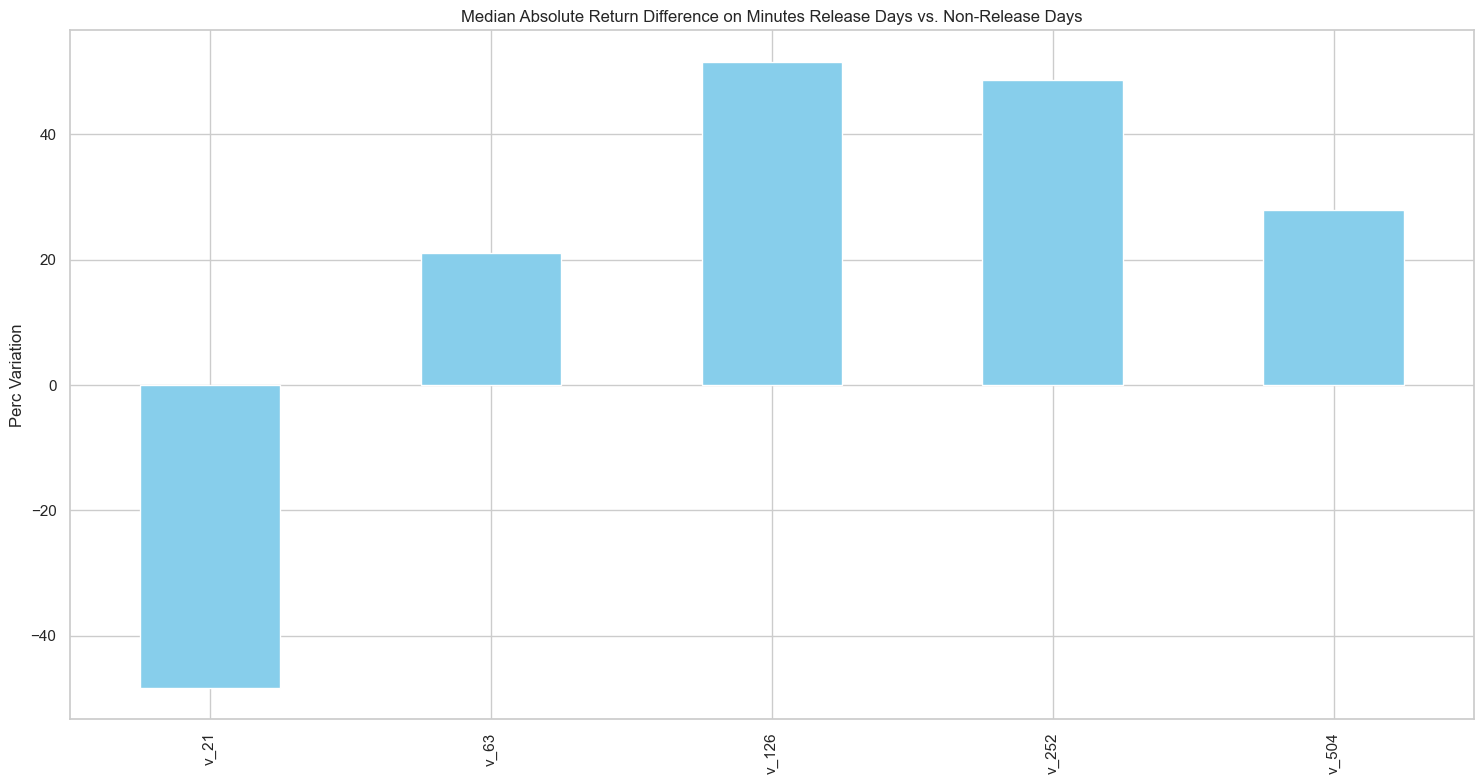

In [16]:
returns_pub_date = futures_ir_returns[futures_ir_returns.index.isin(detes_pub)]
returns_not_pub_date = futures_ir_returns[~(futures_ir_returns.index.isin(detes_pub))]

abs_returns_pub_date = returns_pub_date.abs()
abs_returns_not_pub_date = returns_not_pub_date.abs()

perc_dif_abs_median_return = (abs_returns_pub_date.median()/abs_returns_not_pub_date.median()-1)*100

plt.figure(figsize=(15, 8))
perc_dif_abs_median_return.plot(kind='bar', color='skyblue')
plt.title(f"Median Absolute Return Difference on Minutes Release Days vs. Non-Release Days")
plt.xlabel('')
plt.ylabel('Perc Variation')

plt.tight_layout()

plt.show()